## ***Colorado Land Use Classification Data Upscaling***

The dual goals of this project are to:<br>
>a. Provide a method for upscaling USFS land use classification data in Colorado<br>
>b. Develop proficiency processing and working with satellite data in Python<br>

Google Earth Explorer offers USFS 30x30m resolution land cover classification data and 10x10m resolution Sentinel 2 multispectral imagery data.<br>
This project is based on the hypothesis that enough information should is included in the multispectral data for a given pixel and its surroundings, in order to produce a reasonably accurate prediction as to what land cover class it belongs to.

This project's outcomes include:<br>
>a. A suite of models which can predict land cover classes given Sentinel 2 data<br>
>b. A series of figures detailing the performance of these models<br>
>c. Design explanations - why was each subsequent approach chosen?<br>
>d. An interactive tool which compares model predictions to USFS data in Colorado

### **MODEL 1:** CNN w/ RGB Only
A baseline CNN model using red, green, and blue bands from Sentinel 2 satellite imagery.

This model uses a basic CNN structure of 3 convolutional layers.<br>
The first layer convolutes 32 3x3 kernels across each pixel block and performs max pooling, producing a set of feature maps downscaled by a factor of 2. <br>
The subsequent layers each double the previous number of feature maps and downscale again, extracting more complex patterns from the learned feature maps.<br>

##### **Input**
>Tensor of shape [3, 81, 81] - an 81x81 pixel block of R, G, and B Sentinel 2 bands

##### **Findings** <br>
| Evaluation Confusion matrix: |
| --------------------------------- |
| <img src="rgb_confusion_matrix.png" width="800"> |

<br>

>This model performed surprisingly well predicting USFS classes 4 - 'Grass/Forb/Herb & Trees Mix' and 8 - 'Grass/Forb/Herb & Shrubs Mix',<br> but struggled to differentiate accurately between class 6 - 'Tall Shrubs (SEAK Only)' and >the very similar class 7 - 'Shrubs', and performed less inspiringly on other classes.

### **MODEL 2:** Spatially/Spectrally Attentive CNN w/ RGB + NIR and NDVI

This model builds on the baseline by incorporating both an NIR channel and calculated NDVI channel, along with RGB bands.<br>
Additionally we include a spectral attention mechanism which identifies highly contributing features and a spatial attention mechanism which increases the influence of the central pixel (which we want to identify the class for).<br>
##### **Input**
>Tensor of shape [5, 81, 81] - and 81x81 pixel block of R, G, B, and NIR Sentinel 2 bands, in addition to a calculated NDVI band

##### **Spatial Attention Mechanism**
Since the goal of the model, when provided a pixel block, is to identify the land cover class at the central pixel, we want heighten the influence of that pixel on the output of the model. This is accomplished by creating an attention mask across the block which decreases the influence of pixels the further from they are from the center of the image:

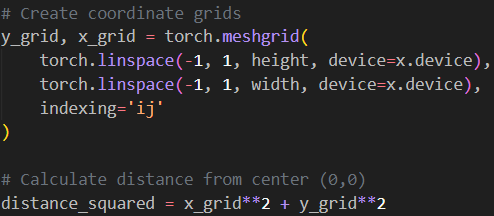

##### **Spectral Attention Mechanism**
Additionally we want the model to focus on which of the many feature maps are relevant to classifying a pixel. This is accomplished by including a spectral attention mechanism in between each convolutional layer.<br>
This mechanism produces an additional attention mask for the following layer, which reduces the influence of feature maps that don't represent features relevant to the prediction task.

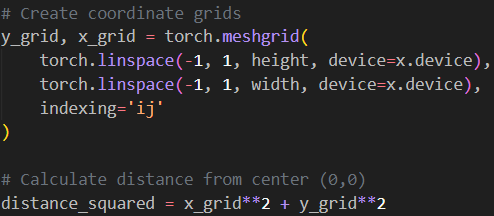

##### **Findings**
| Confusion matrix from evaluation: |
| --------------------------------- |
| <img src="rgb_nir_confusion_matrix.png" width="800"> |

<br>

>This model achieved an overall accuracy of 66%, improving around 10% from the simple baseline model.<br>
>Interestingly, the evaluation confusion matrix shows a lower variation in predictive accuracty between classes than the baseline model, with lower maximum accuracies but a higher average accuracy.
>Additionally, this model mistook class 10 - 'Grass/Forb/Herb' for class 4 - 'Grass/Forb/Herb & Trees Mix' 100% of the time.

### **MODEL 3**: "Time as Channels" CNN

Analyzing a single image - a second in time from above - can only tell us so much about what we see below. Was that green pixel in July also green in December? If so it might be a tree. If not, maybe shrubs or crops. Up to now we have only considered single images from early July in our predictions. This next model expands on the previous spatially and spectrally aware CNN by scaling up the input to include a series of satellite images from early Spring to late Summer (a satellite image time series), instead of just one image.

Many strategies exist to incorporate time series into ML prediction tasks, but as this is a learning project we will start small and examine the concepts motivating the inclusion of time series in this prediction task.

##### **"Time as Channels"**
'Channels' here referring to the shape of our input tensor. With an 81x81 size pixel block and the R, G, B, NIR, and NDVI Bands, our tensor is a 3d array with dimensions:

[5, 81, 81]

Corresponding to a single image. To create a data structure that includes multiple images of the same area you could simply add an additional dimension to the tensor:

[2, 5, 81, 81]

Which now corresponds to 2 images, both with 5 bands and aligned geospatially. Since our basic goal is to include time series information to the model in a way that it can learn temporal relationships, we can simply combine the spectral bands from each image of the same area, such that when  convolution takes place, relationships are learned between the same pixels at different time steps in series. This updated tensor looks like:

[10, 81, 81] 

Where the bands are [R1, G1, B1, NIR1, NDVI1, R2, G2, B2, NIR2, NDVI2]. Looking at images from May to September (with 5 additional bands per month) gives us an input tensor of shape [25, 81, 81]. This gives each pixel context from the spring,
